# Load Libraries for use in Binary Classification
Code Prepared by Joseph Greene: BU ECE M.S Student.

In [ ]:
from kaggle.competitions import twosigmanews
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import datetime as dt
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as plotgo
import plotly.tools as tls

# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

# Method 1: Assume no feature is useless and remove any NaN (Just run one method per training)

In [ ]:
(market_df, news_df) = env.get_training_data() #Load Data

#Lets combine some features in intuitive ways to reduce number of features
#Market Data Reduction
market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume'] #This normalizes the change in cost for one day to per stock [else larger companies could be unfairly weighted more]
market_df['close_to_open'] = market_df['close'] / market_df['open'] #Really what matters is how much closing differs, not each indepedantly
market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean() #This metric marks how much the company's total shares varies compared to the mean. If they're growing a lot or shrinking a lot, this will take that into account  

#News Data Reduction
news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count') #How positively is the environment where an asset is mentioned

#Merges Market Data and News Data into a single Training set
def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x))
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0) #Drops any NaN errors
    
    return market_df

market_train = data_prep(market_df, news_df)
labels = market_train.returnsOpenNextMktres10 >= 0 #Keep conditions where 10 day market price increased for our decision boundary

#fcol = [c for c in market_train.columns if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'assetCodeT', 'volume_to_mean', 'sentence_word_count',
                                            # 'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 'returnsOpenPrevRaw1_to_volume',
                                            # 'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

fcol = [c for c in market_train.columns if c not in['returnsOpenNextMktres10',
                                                  'assetCode','assetName','assetCodesLen','assetCodes']] #Only drop strings, columns that are ALL NaN and 10 day market price, which we are predicting

X = market_train[fcol].values
labels = labels.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Method 2: Data normalization and reduction based on unpredictibility during financial crash and clerical Error

In [ ]:
(market_df, news_df) = env.get_training_data() #Load Data

#Recall from data analysis step, mean change gets crazy during financial crash and some entries are faulty [closing fluctuation is way too big for one day]

#I noticed in a couple kernels that there are occassional errors in dataset. This occurs when an 'openning' price is greatly different then the average
market_df['close_to_open'] =  np.abs(market_df['close'] / market_df['open']) #Normalized ratio of close price to open

market_df['assetName_mean_open'] = market_df.groupby('assetName')['open'].transform('mean')
market_df['assetName_mean_close'] = market_df.groupby('assetName')['close'].transform('mean')
threshold = 0.7

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_df.loc[market_df['close_to_open'] >= (1+threshold)].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_df.loc[market_df['close_to_open'] <= 1-(threshold/2)].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_df.iloc[i,4] = row['assetName_mean_close']
        
#Throw out data from financial crash
market_df = market_df.loc[market_df['time'] >= '2010-01-01 22:00:00+0000']
news_df = news_df.loc[news_df['time'] >= '2010-01-01 22:00:00+0000']

#Merges Market Data and News Data into a single Training set
#Market Data Reduction
market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume'] #This normalizes the change in cost for one day to per stock [else larger companies could be unfairly weighted more]
market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean() #This metric marks how much the company's total shares varies compared to the mean. If they're growing a lot or shrinking a lot, this will take that into account  

#News Data Reduction
news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count') #How positively is the environment where an asset is mentioned

#Now Data Prep
#Merges Market Data and News Data into a single Training set
def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x))
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0) #Drops any NaN errors
    
    return market_df

market_train = data_prep(market_df, news_df)
labels = market_train.returnsOpenNextMktres10 >= 0 #Keep conditions where 10 day market price increased for our decision boundary

fcol = [c for c in market_train.columns if c not in['returnsOpenNextMktres10',
                                                  'assetCode','assetName','assetCodesLen','assetCodes']] #Only drop strings, columns that are ALL NaN and 10 day market price, which we are predicting

X = market_train[fcol].values
labels = labels.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Method 3: Remove Low Importance Features as well as Data Reduction in Method 2

In [ ]:
(market_df, news_df) = env.get_training_data() #Load Data

#Recall from data analysis step, mean change gets crazy during financial crash and some entries are faulty [closing fluctuation is way too big for one day]

#I noticed in a couple kernels that there are occassional errors in dataset. This occurs when an 'openning' price is greatly different then the average
market_df['close_to_open'] =  np.abs(market_df['close'] / market_df['open']) #Normalized ratio of close price to open

market_df['assetName_mean_open'] = market_df.groupby('assetName')['open'].transform('mean')
market_df['assetName_mean_close'] = market_df.groupby('assetName')['close'].transform('mean')
threshold = 0.7

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_df.loc[market_df['close_to_open'] >= (1+threshold)].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_df.loc[market_df['close_to_open'] <= 1-(threshold/2)].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_df.iloc[i,4] = row['assetName_mean_close']
        
#Throw out data from financial crash
market_df = market_df.loc[market_df['time'] >= '2010-01-01 22:00:00+0000']
news_df = news_df.loc[news_df['time'] >= '2010-01-01 22:00:00+0000']

#Merges Market Data and News Data into a single Training set
#Market Data Reduction
market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume'] #This normalizes the change in cost for one day to per stock [else larger companies could be unfairly weighted more]
market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean() #This metric marks how much the company's total shares varies compared to the mean. If they're growing a lot or shrinking a lot, this will take that into account  

#News Data Reduction
news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count') #How positively is the environment where an asset is mentioned

#Now Data Prep
#Merges Market Data and News Data into a single Training set
def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x))
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0) #Drops any NaN errors
    
    return market_df

market_train = data_prep(market_df, news_df)
labels = market_train.returnsOpenNextMktres10 >= 0 #Keep conditions where 10 day market price increased for our decision boundary

fcol = [c for c in market_train.columns if c not in['returnsOpenNextMktres10',
                                                  'assetCode','assetName','assetCodesLen','assetCodes',
                                                  'volume_to_mean', 'returnsOpenPrevRaw1_to_volume','firstCreated',
                                                  'firstCreated','sourceTimestamp','universe',
                                                  'marketCommentary','noveltyCount24H','noveltyCount3D','noveltyCount5D']] #Only drop strings, columns that are ALL NaN and 10 day market price, which we are predicting

X = market_train[fcol].values
labels = labels.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

In [ ]:
market_train.head(5)

In [ ]:
X_train, X_test, labels_train, labels_test, r_train, r_test = train_test_split(X, labels, r, test_size=0.3, random_state=99)

In [ ]:
params = {'learning_rate': 0.00001,#Our used learning rate determined experimentally
          'boosting': 'rf', #Method: Gradient Boosted Decision Tree (other methods used for comparison)
          'objective': 'binary',#Goal: Binary Classification 
          'metric': 'binary_logloss', #Metric: The Binary Logloss function used in class
          'max_depth': -1, #No limit on tree depth
          'is_training_metric': True, 
          'seed': 42,
         'bagging_freq': 50,
         'bagging_fraction': 0.75,
         'feature_fraction': 0.25} 
model = lgb.train(params, 
                  train_set=lgb.Dataset(X_train, label=labels_train), 
                  num_boost_round= 10000,
                  valid_sets=[lgb.Dataset(X_train, label=labels_train), 
                              lgb.Dataset(X_test, label=labels_test)],
                  verbose_eval=1000, 
                  early_stopping_rounds=50)

In [ ]:
#Test Model
y_pred = model.predict(X_test,num_iteration = model.best_iteration) #Probability of class 1 or 0
y_pred[y_pred >= 0.5] = 1 #Binary so either confident it goes up or down
y_pred[y_pred < 0.5] = -1
#Determine Accuracy
y_bool = y_pred >= 0 #Apply boolean mask to get TF labels
acc = ~(y_bool ^ labels_test) #XNOR operation so 1 1 and 0 0 returns true, else false
print(np.sum(acc)/len(acc))

In [ ]:
#Precision and Recall Calculation
true_pos = np.zeros((y_bool).shape)
false_neg = np.zeros((y_bool).shape)
false_pos= np.zeros((y_bool).shape)

for i in range(1,len(y_bool)):
    if((y_bool[i] and labels_test[i]).any()):
        true_pos[i] = True
        false_neg[i] = False
        false_pos[i] = False
    elif((~y_bool[i] and labels_test[i]).any()):
        true_pos[i] = False
        false_neg[i] = True
        false_pos[i] = False
    elif((y_bool[i] and ~labels_test[i]).any()):
        true_pos[i] = False
        false_neg[i] = False
        false_pos[i] = True
    else:
        true_pos[i] = False
        false_neg[i] = False
        false_pos[i] = False
p = np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_pos))
r = np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_neg))
print(p,r)

In [ ]:
#Sigma Score
x = y_pred * r_test
sigma = np.mean(x)/np.var(x)
print(sigma)

In [ ]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': model.feature_importance(), 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
data = [df]
for dd in data:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())

    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=12),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of LGB',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')
    print(df)

# Appendix A: Data Trends

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as plotgo
import plotly.tools as tls

#Load Training data and compare sizes
(market_train_df, news_train_df) = env.get_training_data()
print('Market data size',market_train_df.shape,'News data size',news_train_df.shape)

#Lets randomly sample 15 companies and their closing price trends [Note, not all prices are continuous! They drop out and disappear!]
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(plotgo.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = plotgo.Layout(dict(title = "Closing prices of 15 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
(market_train_df, news_train_df) = env.get_training_data() #Load Data

#Analyze the general trends of stock behavior based on quantile (does wealth matter?)
data = []
#Group market dataset into quantiles and graph behaviors of stocks of differnet prices over time
for i in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(plotgo.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = plotgo.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="v"),
                      annotations=[
        dict(
            x='2008-09-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Housing Market Crash',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#FF0000'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=60,
            ay=-50,
            borderwidth=2,
            borderpad=4,
            opacity=0.8
        ),
        dict(
            x='2011-08-01 22:00:00+0000',
            y=85,
            xref='x',
            yref='y',
            text='Black Monday',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#FF0000'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            borderwidth=2,
            borderpad=4,
            opacity=0.8
        ),
        dict(
            x='2016-01-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Oil prices crash',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#FF0000'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            borderwidth=2,
            borderpad=4,
            opacity=0.8
        )
    ])
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
#Now Let's look at those 10 day return prices and see how they look graphically.
data = []
for i in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(plotgo.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = plotgo.Layout(dict(title = "returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="v"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
#Mean of data
data = []

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(plotgo.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = plotgo.Layout(dict(title = "returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Notice that the mean return price of the training set becomes incredibly sporadic during the market crash. What if we remove this data under the presumption that training our models DURING a crash has no value since we are out of a crash.

In [ ]:
#Mean of data
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000'] #Filter Data so first two years removed

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(plotgo.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = plotgo.Layout(dict(title = "returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
#What are the most common words used in headlines?
text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [ ]:
#Tag breakdowns
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot('barh');
plt.title('headlineTag counts (thousands)');

In [ ]:
#Companies mentioned during sentiment
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

# Appendix B: Comparing less accurate models

In [ ]:
params = {'learning_rate': 0.01,#Our used learning rate determined experimentally
          'boosting': 'goss', #Method: Gradient-based One Sided Sampling
          'objective': 'binary',#Goal: Binary Classification 
          'metric': 'binary_logloss', #Metric: The Binary Logloss function used in class
          'max_depth': -1, #No limit on tree depth
          'is_training_metric': True, 
          'seed': 42} 
model = lgb.train(params, 
                  train_set=lgb.Dataset(X_train, label=labels_train), 
                  num_boost_round= 10000,
                  valid_sets=[lgb.Dataset(X_train, label=labels_train), 
                              lgb.Dataset(X_test, label=labels_test)],
                  verbose_eval= 500, 
                  early_stopping_rounds=50)

#Test Model
y_pred = model.predict(X_test,num_iteration = model.best_iteration) #Probability of class 1 or 0
y_pred[y_pred >= 0.5] = 1 #Binary so either confident it goes up or down
y_pred[y_pred < 0.5] = -1
#Determine Accuracy
y_bool = y_pred >= 0 #Apply boolean mask to get TF labels
acc = ~(y_bool ^ labels_test) #XNOR operation so 1 1 and 0 0 returns true, else false
print(np.sum(acc)/len(acc))

In [ ]:
params = {'learning_rate': 0.025,#Our used learning rate determined experimentally
          'boosting': 'gbdt', #Method: Gradient Boosted Decision Tree (other methods used for comparison)
          'objective': 'binary',#Goal: Binary Classification 
          'metric': 'binary_logloss', #Metric: The Binary Logloss function used in class
          'max_depth': -1, #No limit on tree depth
          'is_training_metric': True, 
          'seed': 42} 
model = lgb.train(params, 
                  train_set=lgb.Dataset(X_train, label=labels_train), 
                  num_boost_round= 1, #For comparison how does just a single weak learner do?
                  valid_sets=[lgb.Dataset(X_train, label=labels_train), 
                              lgb.Dataset(X_test, label=labels_test)],
                  verbose_eval=1000, 
                  early_stopping_rounds=50)

#Test Model
y_pred = model.predict(X_test,num_iteration = model.best_iteration) #Probability of class 1 or 0
y_pred[y_pred >= 0.5] = 1 #Binary so either confident it goes up or down
y_pred[y_pred < 0.5] = -1
#Determine Accuracy
y_bool = y_pred >= 0 #Apply boolean mask to get TF labels
acc = ~(y_bool ^ labels_test) #XNOR operation so 1 1 and 0 0 returns true, else false
print(np.sum(acc)/len(acc))

# Appendix C: Explaining the Models

How does gradient boosted decision tree works?

   Gradient Boosted Decision Trees (GBDT) are a form of supervised learning where we traing a procedurally generated series of weak learnings that attempt to improve on the flaws of the previous iterations. Each weak learner is a 'tree' is a series of weighted decisions generated by the information accessable through the provided data. Each tree has a certain amount of 'nodes' or total amount of catagories a tree may split into. Normally a decision tree with a depth of m [how many weighted decisions each tree path contains] has 2^m leaves, or 2 catagories per decision. So, when you wish to predict the outcome for a variable x, the information for x is used by each layer in the decision tree and the when the variable is catagorized, the weight assigned the decided on nodes are added together. For a binary decision [like whether a stock will increase or decrease] if the added weight is positive, the stock will be predicted to increases, and negative means the stock will decrease. Gradient Boosted refers to the fact that the utilized loss function is differentiable. Therefore, each weight may be updated a gradient descent algorithm. Therefore the next tree in the series will, ideally, be a better [but still weak as in only utilizes a finite amount of information] classifier. Since a new tree is generated after every iteration, a variable is decided upon by all generated trees and the final verdict is determined by a majority vote. Note: GDBT does not have native sample weights and therefore does not begin by knowing how important data is. It figures out this information by randomly sampling the data between iterations.

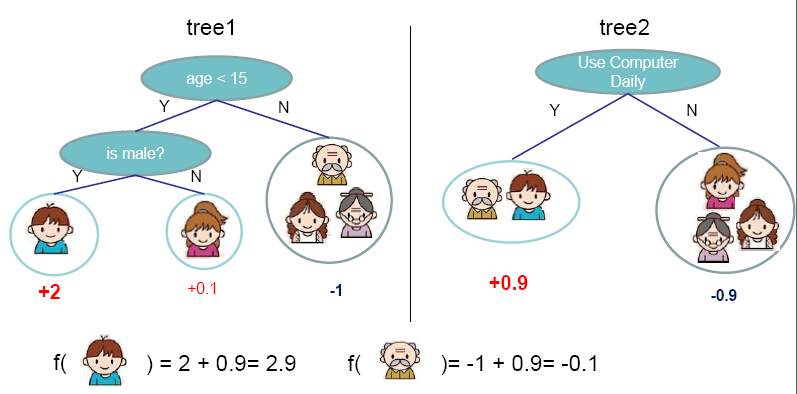

ref: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
  
  

   Gradient-based One Sided Sampling (GOSS) is a type of GBDT that relies on determining how the selected data affects the information gain the model. Information gain is a quantity that dictates how much information one gains about a random variable by observing another random variable and can have a large degree of importance when attempting to determine trends in psuedo-random variables like our stock prices. Information gain is the relative entropy between the probability distribution of one random variable and the conditional distribution of the other. An important aspect is the expected information gain given a given attribute. To define this value, lets define H as the information entropy (for a distribution P(i), H(P(i)) = sum(P(i) * ln(P(i))). Therefore, the expected information gain may be described as H(P(i)) - H(P(i)|a) where a is an attribute. As stated in the referrenced paper, data instances with larger gradients contribute more in information gain (i.e our model can still gain a lot of information by these instances). Therefore, in random sampling of the training set (as decision trees tend to do tp speed up the algorithm and so different models may emphasize different features) the instances with large gradients are kept and those with smaller gradients are randomly dropped.
   
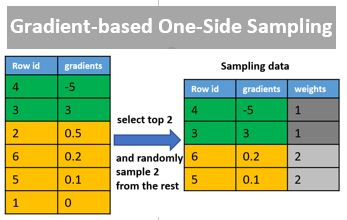
   
   ref: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf
   
   Please Note: We use another boosting method in our poster: XGBoost. This decision tree is different in how it chooses to sample data and doesn't have GOSS. More info may be found here:
   
   ref: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db


# Submission to Kaggle

In [ ]:
days = env.get_prediction_days()
import time

n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if n_days % 50 == 0:
        print(n_days,end=' ')
    
    t = time.time()
    market_obs_df = data_prep(market_obs_df, news_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    lp = model.predict(X_live)
    prediction_time += time.time() -t
    
    t = time.time()
    confidence = 2 * lp -1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()